## Libraries

In [1]:
# Standard libs
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 100)
import os
import pickle




# Utilities
from utils.viz_utils import *
from utils.custom_transformers import *
from utils.ml_utils import *


# Pipeline 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Setting of plot : 
from sklearn import set_config
set_config(display="diagram")
sns.set_style("whitegrid")
font_title = {"family": "serif",
              "color":  "#476bff",
              "weight": "bold",
              "size": 18}


In [2]:
# Modeling
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate


In [3]:
from sklearn.feature_selection import RFECV

In [16]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Chargement des données : 
data_train = pd.read_csv('data_train.csv', encoding ='utf-8', index_col='SK_ID_CURR',nrows=30000)
print(f'Notre dataset a pour dimension: {data_train.shape[0]} client et {data_train.shape[1]} features')
display(data_train.head())

Notre dataset a pour dimension: 30000 client et 262 features


CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100002                 0          202500.0    406597.5      24700.5   
100003                 0          270000.0   1293502.5      35698.5   
100004                 0           67500.0    135000.0       6750.0   
100006                 0          135000.0    312682.5      29686.5   
100007                 0          121500.0    513000.0      21865.5   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
100002             351000.0                    0.018801        9461   
100003            1129500.0                    0.003541       16765   
100004             135000.0                    0.010032       19046   
100006             297000.0                    0.008019       19005   
100007             513000.0                    0.028663       19932   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
SK_ID_CURR                                                                  
100002             -637.0            -3648.0            -2120           1   
100003            -1188.0            -1186.0             -291           1   
100004             -225.0            -4260.0            -2531           1   
100006            -3039.0            -9833.0            -2437           1   
100007            -3038.0            -4311.0            -3458           1   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
100002                   1                0                 1           1   
100003                   1                0                 1           1   
100004                   1                1                 1           1   
100006                   1                0                 1           0   
100007                   1                0                 1           0   

            FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                      
100002               0              1.0                     2   
100003               0              2.0                     1   
100004               0              1.0                     2   
100006               0              2.0                     2   
100007               0              1.0                     2   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
100002                                2                       10   
100003                                1                       11   
100004                                2                        9   
100006                                2                       17   
100007                                2                       11   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
100002                               0                           0   
100003                               0                           0   
100004                               0                           0   
100006                               0                           0   
100007                               0                           0   

            LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                                                        
100002                                0                       0   
100003                                0                       0   
100004                                0                       0   
100006                                0                       0   
100007                                0                       0   

            REG_CITY_NOT_WORK_CITY  LIVE_C

In [5]:
TARGET = pd.read_csv('TARGET.csv',  encoding ='utf-8', index_col='SK_ID_CURR',nrows=30000)
print(f'Notre TARGET a pour dimension: {TARGET.shape[0]} client et {TARGET.shape[1]} features')
display(TARGET.head())

Notre TARGET a pour dimension: 30000 client et 1 features


TARGET
SK_ID_CURR        
100002         1.0
100003         0.0
100004         0.0
100006         0.0
100007         0.0

In [6]:
### Standardisation des données
from sklearn.preprocessing import  MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(data_train)
scaled_train = scaler.transform(data_train)

### Imputation des valeurs manquantes 

L'une des approches les plus simples consiste à remplacer les NaN par la Médiane (ou Moyenne) pour les variables correspondantes

In [7]:
print('Missing values in train data: ', sum(data_train.isnull().sum()))
X = data_train.copy()

Missing values in train data:  1128587


In [8]:
# Splitting the data by dtype
num_features = [col for col, dtype in data_train.dtypes.items() if dtype != 'object']

# Building a numerical pipeline
num_pipeline = Pipeline([
    ('median_imputer', SimpleImputer(strategy='median'))
])


# Building a complete pipeline
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features)
])

In [9]:
X = full_pipeline.fit_transform(X)

In [10]:
X.shape

(30000, 252)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, TARGET.values, test_size=0.3, random_state=42)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21000, 252), (9000, 252), (21000, 1), (9000, 1))

## Baseline model - Logistic Regression 


Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [17]:
# Logistic Regression hyperparameters   
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 5),
    'penalty': ['l1', 'l2','elasticnet'],
    'class_weight': ['balanced', None],
    'random_state': [22],
    'solver': ['saga']
}
mlr_grid_cv = RandomizedSearchCV(LogisticRegression(), logreg_param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
mlr_grid_cv.fit(X_train, y_train)
best_logreg_params = mlr_grid_cv.best_params_


AUC : 0.5521
              precision    recall  f1-score   support

         0.0       0.92      0.57      0.71      8266
         1.0       0.09      0.46      0.15       734

    accuracy                           0.56      9000
   macro avg       0.50      0.52      0.43      9000
weighted avg       0.85      0.56      0.66      9000

LogisticRegression:


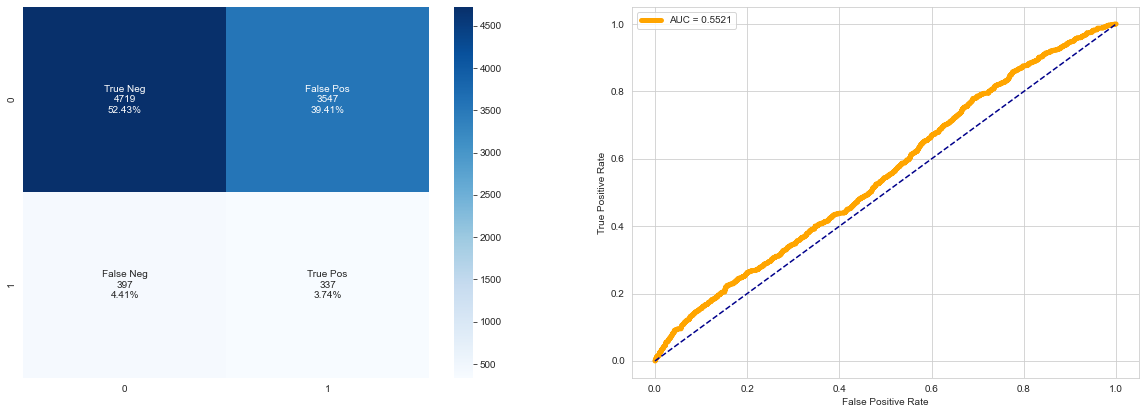

In [18]:
mlr = LogisticRegression(**best_logreg_params)
mlr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, mlr.predict_proba(X_test)[:,1])
print("=="*50)
print('AUC : %0.4f' %roc_auc)
print("=="*50)
print(classification_report(y_test, mlr.predict(X_test)))
print("=="*50)
print('LogisticRegression:')
cf_matrix_roc_auc(mlr, y_test, mlr.predict(X_test), mlr.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc,X_data=None)

Notons un fort déséquilibre entre la précision trouvée pour la Target 0 (0.92) et la Target 1 (0). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement de crédit..


### Oversampling Data Using SMOTE 

Il est donc intéressant de travailler cet **Oversampling (ou suréchantillonnage en français)**  en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire

In [20]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: [1669] 
Label 0, Before using SMOTE: [19331] 


In [21]:
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [22]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 19331
Label 0, After using SMOTE: 19331


In [23]:
mlr_grid_cv.fit(X_train_res, y_train_res)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': array([ 0.1  ,  2.575,  5.05 ,  7.525, 10.   ]),
                                        'class_weight': ['balanced', None],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'random_state': [22],
                                        'solver': ['saga']},
                   scoring='roc_auc')

AUC : 0.5699
              precision    recall  f1-score   support

         0.0       0.93      0.53      0.67      8266
         1.0       0.09      0.55      0.16       734

    accuracy                           0.53      9000
   macro avg       0.51      0.54      0.42      9000
weighted avg       0.86      0.53      0.63      9000

LogisticRegression:


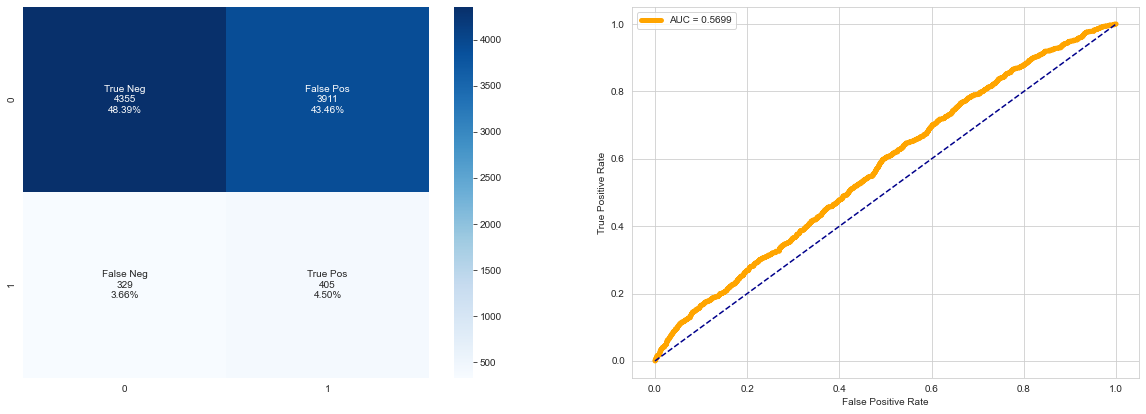

In [24]:
mlr_res = LogisticRegression(**mlr_grid_cv.best_params_)
mlr_res.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, mlr_res.predict_proba(X_test)[:,1])
print("=="*50)
print('AUC : %0.4f' %roc_auc)
print("=="*50)
print(classification_report(y_test, mlr_res.predict(X_test)))
print("=="*50)
print('LogisticRegression:')
cf_matrix_roc_auc(mlr_res, y_test, mlr_res.predict(X_test), mlr_res.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc,X_data=None)

### Model :RandomForest et Arbre de décision 
#### Arbre de décision 

In [25]:
# Decision Trees hyperparameters
tree_param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [3, 5, 10, 20],
    'max_features': np.arange(1, X_train.shape[1]),
    'class_weight': ['balanced', None],
    'random_state': [42]
}
mdtc_grid_cv = RandomizedSearchCV(DecisionTreeClassifier(), tree_param_grid , scoring='roc_auc', cv=5,  n_jobs=-1)
mdtc_grid_cv.fit(X_train, y_train)
best_tree_params = mdtc_grid_cv.best_params_

AUC : 0.6514
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      8266
         1.0       0.32      0.01      0.02       734

    accuracy                           0.92      9000
   macro avg       0.62      0.50      0.49      9000
weighted avg       0.87      0.92      0.88      9000

DecisionTreeClassifier():


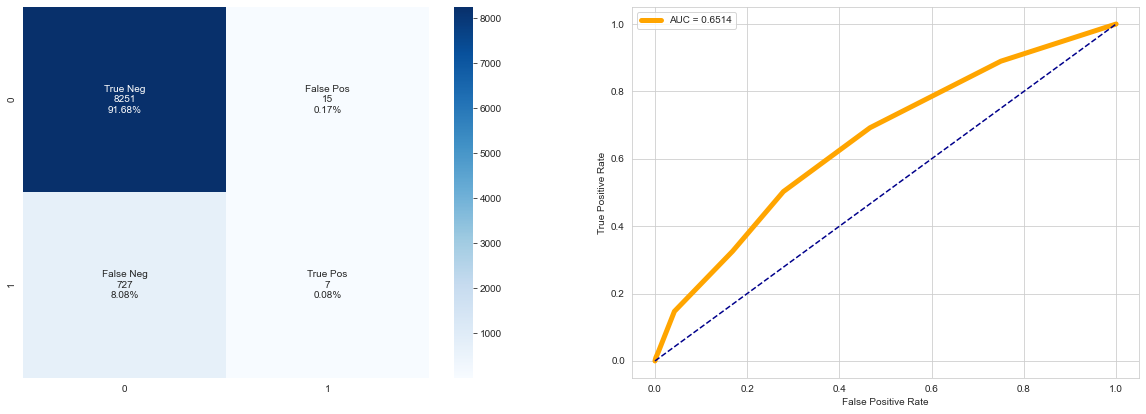

In [26]:
mdtc = DecisionTreeClassifier(**best_tree_params)
mdtc.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, mdtc.predict_proba(X_test)[:,1])
print("=="*50)
print('AUC : %0.4f' %roc_auc)
print("=="*50)
print(classification_report(y_test, mdtc.predict(X_test)))
print("=="*50)
print('DecisionTreeClassifier():')
cf_matrix_roc_auc(mdtc, y_test, mdtc.predict(X_test), mdtc.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc,X_data=None)

____
* _SMOTE_
____

In [27]:
mdtc_grid_cv.fit(X_train_res, y_train_res)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 10, 20],
                                        'max_features': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,...
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251]),
                                        'random_state': [42]},
                   scoring='roc_auc')

AUC : 0.5509
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92      8266
         1.0       0.13      0.15      0.14       734

    accuracy                           0.85      9000
   macro avg       0.53      0.53      0.53      9000
weighted avg       0.86      0.85      0.85      9000

DecisionTreeClassifier():


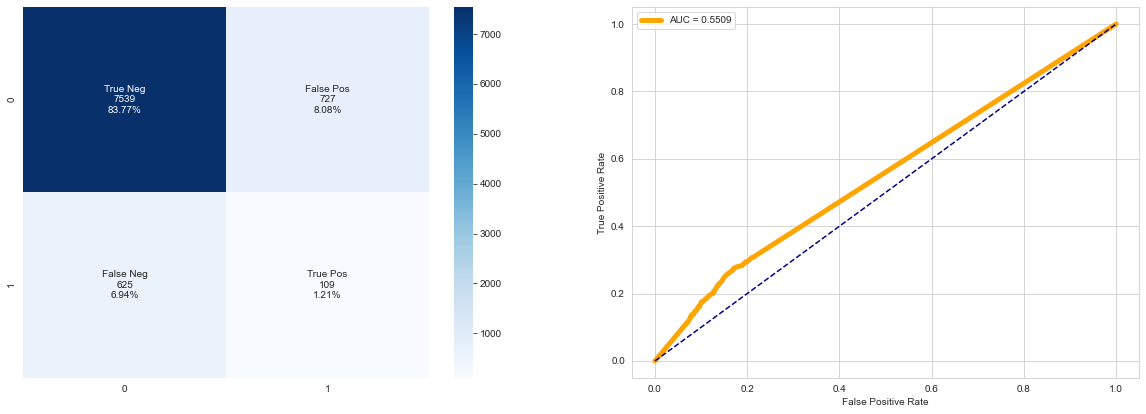

In [28]:
mdtc_res = DecisionTreeClassifier(**mdtc_grid_cv.best_params_)
mdtc_res.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, mdtc_res.predict_proba(X_test)[:,1])
print("=="*50)
print('AUC : %0.4f' %roc_auc)
print("=="*50)
print(classification_report(y_test, mdtc_res.predict(X_test)))
print("=="*50)
print('DecisionTreeClassifier():')
cf_matrix_roc_auc(mdtc_res, y_test, mdtc_res.predict(X_test), mdtc_res.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc,X_data=None)

#### RandomForest

In [30]:
# Random Forest hyperparameters
forest_param_grid = {
    'bootstrap': [True, False],
    'max_depth': [3, 5, 10, 20, 50],
    'n_estimators': [50, 100, 200, 500],
    'random_state': [22],
    'max_features': ['auto', 'sqrt'],
    'class_weight': ['balanced', None]
}

mrf_grid_cv = RandomizedSearchCV(RandomForestClassifier(), forest_param_grid , scoring='roc_auc', cv=5,  n_jobs=-1)
mrf_grid_cv.fit(X_train, y_train)
best_forest_params = mrf_grid_cv.best_params_


AUC : 0.7181
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      8266
         1.0       0.00      0.00      0.00       734

    accuracy                           0.92      9000
   macro avg       0.46      0.50      0.48      9000
weighted avg       0.84      0.92      0.88      9000

RandomForestClassifier:


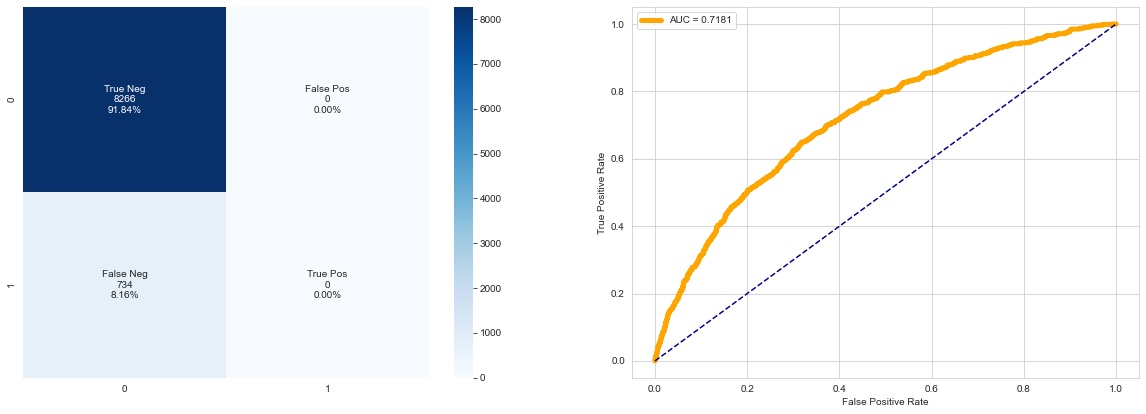

In [31]:
mrf = RandomForestClassifier(**best_forest_params)
mrf.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, mrf.predict_proba(X_test)[:,1])
print("=="*50)
print('AUC : %0.4f' %roc_auc)
print("=="*50)
print(classification_report(y_test, mrf.predict(X_test)))
print("=="*50)
print('RandomForestClassifier:')
cf_matrix_roc_auc(mrf, y_test, mrf.predict(X_test), mrf.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc,X_data=None)

____
* _SMOTE_
____

In [32]:
mrf_grid_cv.fit(X_train_res, y_train_res)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None],
                                        'max_depth': [3, 5, 10, 20, 50],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [50, 100, 200, 500],
                                        'random_state': [22]},
                   scoring='roc_auc')

AUC : 0.6977
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      8266
         1.0       1.00      0.00      0.00       734

    accuracy                           0.92      9000
   macro avg       0.96      0.50      0.48      9000
weighted avg       0.93      0.92      0.88      9000

RandomForestClassifier:


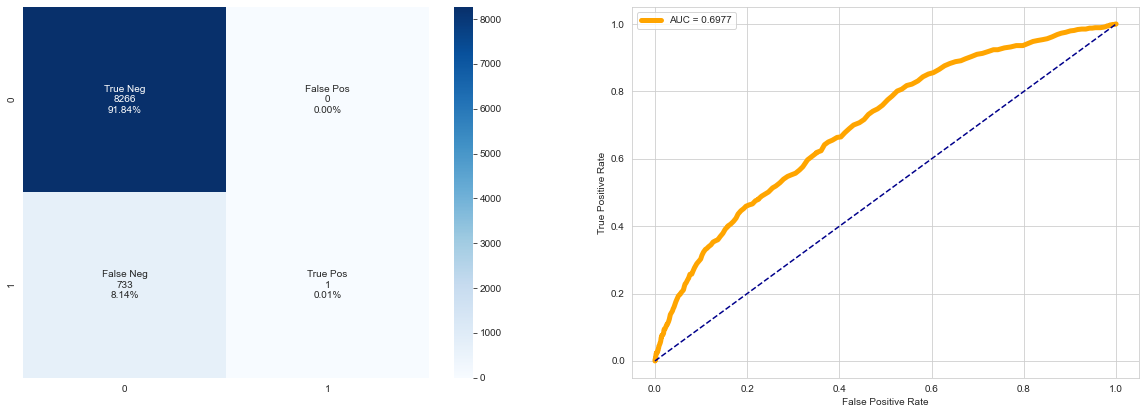

In [33]:
mrf_res = RandomForestClassifier(**mrf_grid_cv.best_params_)
mrf_res.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, mrf_res.predict_proba(X_test)[:,1])
print("=="*50)
print('AUC : %0.4f' %roc_auc)
print("=="*50)
print(classification_report(y_test, mrf_res.predict(X_test)))
print("=="*50)
print('RandomForestClassifier:')
cf_matrix_roc_auc(mrf_res, y_test, mrf_res.predict(X_test), mrf_res.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc,X_data=None)

____
* _Recapitulatif_
____

In [34]:
models = [
         LogisticRegression(**best_logreg_params),
         DecisionTreeClassifier(**best_tree_params),
         RandomForestClassifier(**best_forest_params)]

In [35]:
name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = classify_train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

In [36]:
base_models.reset_index(drop=True).style.background_gradient(cmap='Blues')

### Feature Selection - Recursive Feature Elimination 

Maintenant que nous avons testé ces 3 modèles, on peut effectuer cette étape avec `RandomForest` qui permet d'obtenir les meilleurs performances AUC score / Time. À ce stade, nos ensembles de données contiennent **`261 features`**, dont beaucoup peuvent ne pas contenir d'informations utiles. RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC tout en éliminant les features les moins importantes.

In [38]:
start = time.time()
rfecv = RFECV(estimator=RandomForestClassifier(**best_forest_params), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              n_jobs=-1)
rfecv.fit(X_train, y_train)

print('Time Elapsed: {}'.format(time.time()-start))

Time Elapsed: 13148.369104385376


In [39]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("=="*50)
print("Selected Features: %s" % rfecv.support_[:25])
print("=="*50)
print("Feature Ranking : %s" % rfecv.ranking_[:25])

Optimal number of features : 152
Selected Features: [ True  True  True  True  True  True  True  True  True  True False  True
  True False  True  True  True  True  True  True False  True False  True
  True]
Feature Ranking : [ 1  1  1  1  1  1  1  1  1  1 19  1  1 20  1  1  1  1  1  1  3  1  5  1
  1]


RFECV conserve les features avec un **`Rank 1 > True`**. Ci-dessous une vérification de la sélection de Rank 1…

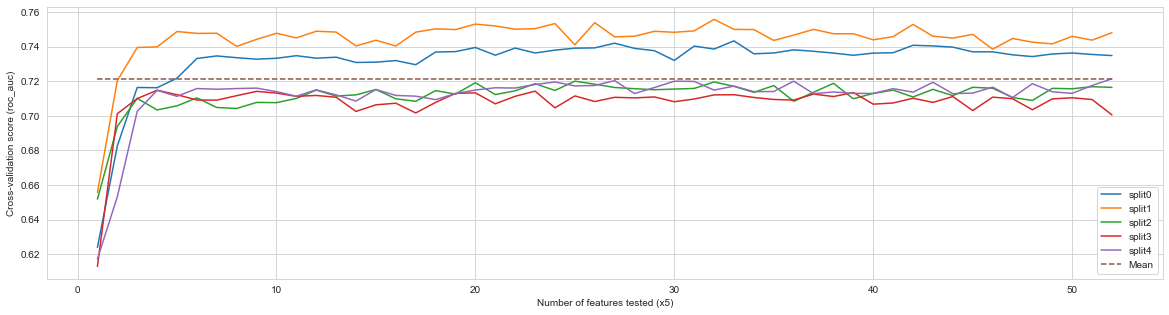

In [40]:
#Plot number of features vs CV scores
split=5
x = range(1, len(rfecv.grid_scores_) + 1)
y = rfecv.grid_scores_
y_mean = [np.mean(y)]*len(x)

fig,ax = plt.subplots(figsize=(20, 5))

# Plot the data
data_line = ax.plot(x,y, label=['split'+ str(x) for x in range(split)])

# Plot the average line
mean_line = ax.plot(x,y_mean, label='Mean', linestyle='--')

# Make a legend
legend = ax.legend(loc='best')
plt.xlabel('Number of features tested (x%d)' % split)
plt.ylabel('Cross-validation score (roc_auc)')

plt.show()

RFECV explique l'importance des features sélectionnées en fonction de l'évolution du score AUC, comme l'atteste également le plot ci-dessus.

In [41]:
data_train.iloc[:X_train.shape[0],:X.shape[1]]

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100002                 0          202500.0    406597.5      24700.5   
100003                 0          270000.0   1293502.5      35698.5   
100004                 0           67500.0    135000.0       6750.0   
100006                 0          135000.0    312682.5      29686.5   
100007                 0          121500.0    513000.0      21865.5   
...                  ...               ...         ...          ...   
124467                 0          225000.0   1091677.5      43425.0   
124468                 2          225000.0    248760.0      29650.5   
124469                 1          112500.0    691020.0      26905.5   
124470                 0          148500.0    808650.0      23773.5   
124471                 2          225000.0    225000.0      11250.0   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
100002             351000.0                    0.018801        9461   
100003            1129500.0                    0.003541       16765   
100004             135000.0                    0.010032       19046   
100006             297000.0                    0.008019       19005   
100007             513000.0                    0.028663       19932   
...                     ...                         ...         ...   
124467             936000.0                    0.006852       14601   
124468             225000.0                    0.046220       10731   
124469             495000.0                    0.018801        9654   
124470             675000.0                    0.018029       18917   
124471             225000.0                    0.020246       15585   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
SK_ID_CURR                                                                  
100002             -637.0            -3648.0            -2120           1   
100003            -1188.0            -1186.0             -291           1   
100004             -225.0            -4260.0            -2531           1   
100006            -3039.0            -9833.0            -2437           1   
100007            -3038.0            -4311.0            -3458           1   
...                   ...                ...              ...         ...   
124467             -199.0            -4226.0            -4424           1   
124468            -1557.0             -179.0            -2272           1   
124469            -2969.0            -9654.0            -1252           1   
124470                NaN            -4104.0            -2456           1   
124471            -2786.0            -3615.0            -4787           1   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
100002                   1                0                 1           1   
100003                   1                0                 1           1   
100004                   1                1                 1           1   
100006                   1                0                 1           0   
100007                   1                0                 1           0   
...                    ...              ...               ...         ...   
124467                   1                0                 1           0   
124468                   1                0                 1           0   
124469                   1                1                 1           1   
124470                   0                0                 1           0   
124471                   1                0                 1           1   

            FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                      
100002               0        

In [44]:
ranking = pd.DataFrame({'Features': data_train.columns})
ranking['RANK'] = pd.Series(np.asarray(rfecv.ranking_))
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))

152


In [45]:
#X_data is very important to implement the feature importance plot...
X_data = pd.DataFrame(X,columns=data_train.columns[:X.shape[1]],index=data_train.index[:X.shape[0]])
X_data = X_data[features_selection]
print("Dimension de X_data:")
display(X_data.shape)
print("=="*50)
print("X_data head:")
display(X_data.head())

Dimension de X_data:


(30000, 152)

X_data head:


CNT_CHILDREN  PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE  \
SK_ID_CURR                                                          
100002               0.0                                23778.594   
100003               0.0                                23778.594   
100004               0.0                                23778.594   
100006               0.0                                    0.000   
100007               0.0                                23778.594   

            PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE  \
SK_ID_CURR                                         
100002                              24573.831266   
100003                              24573.831266   
100004                              24573.831266   
100006                                  0.000000   
100007                              24573.831266   

            PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL  \
SK_ID_CURR                                                     
100002                                          24573.831266   
100003                                          24573.831266   
100004                                          24573.831266   
100006                                              0.000000   
100007                                          24573.831266   

            PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT  \
SK_ID_CURR                                                      
100002                                               0.333333   
100003                                               0.333333   
100004                                               0.333333   
100006                                               0.333333   
100007                                               0.333333   

            PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT  \
SK_ID_CURR                                                  
100002                                               0.24   
100003                                               0.24   
100004                                               0.24   
100006                                               0.00   
100007                                               0.24   

            PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT  \
SK_ID_CURR                                                        
100002                                                    0.0     
100003                                                    0.0     
100004                                                    0.0     
100006                                                    0.0     
100007                                                    0.0     

            PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT  \
SK_ID_CURR                                                      
100002                                                  0.125   
100003                                                  0.125   
100004                                                  0.125   
100006                                                  0.125   
100007                                                  0.125   

            PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY  \
SK_ID_CURR                                                     
100002                                                   3.0   
100003                                                   3.0   
100004                                                   3.0   
100006                                                   0.0   
100007                                                   3.0   

            PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL  \
SK_ID_CURR                                             
100002                                   4183.808276   
100003                                   4183.808276   
100004                                   4183.808276   
100006                                      0.000000   
100007                                   4183.808276   

            PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT  \
SK

In [46]:
#Merge operation with TARGET before save this reduced sample
X_data = X_data.merge(TARGET, left_index=True, right_index=True)

In [47]:
print(f'Nous avons dans notre jeux donner utile {X_data.shape[0]} client et {X_data.shape[1]} qui les caratérise.')
print("=="*50)
display(X_data.head())

Nous avons dans notre jeux donner utile 30000 client et 153 qui les caratérise.


CNT_CHILDREN  PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE  \
SK_ID_CURR                                                          
100002               0.0                                23778.594   
100003               0.0                                23778.594   
100004               0.0                                23778.594   
100006               0.0                                    0.000   
100007               0.0                                23778.594   

            PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE  \
SK_ID_CURR                                         
100002                              24573.831266   
100003                              24573.831266   
100004                              24573.831266   
100006                                  0.000000   
100007                              24573.831266   

            PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL  \
SK_ID_CURR                                                     
100002                                          24573.831266   
100003                                          24573.831266   
100004                                          24573.831266   
100006                                              0.000000   
100007                                          24573.831266   

            PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT  \
SK_ID_CURR                                                      
100002                                               0.333333   
100003                                               0.333333   
100004                                               0.333333   
100006                                               0.333333   
100007                                               0.333333   

            PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT  \
SK_ID_CURR                                                  
100002                                               0.24   
100003                                               0.24   
100004                                               0.24   
100006                                               0.00   
100007                                               0.24   

            PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT  \
SK_ID_CURR                                                        
100002                                                    0.0     
100003                                                    0.0     
100004                                                    0.0     
100006                                                    0.0     
100007                                                    0.0     

            PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT  \
SK_ID_CURR                                                      
100002                                                  0.125   
100003                                                  0.125   
100004                                                  0.125   
100006                                                  0.125   
100007                                                  0.125   

            PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY  \
SK_ID_CURR                                                     
100002                                                   3.0   
100003                                                   3.0   
100004                                                   3.0   
100006                                                   0.0   
100007                                                   3.0   

            PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL  \
SK_ID_CURR                                             
100002                                   4183.808276   
100003                                   4183.808276   
100004                                   4183.808276   
100006                                      0.000000   
100007                                   4183.808276   

            PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT  \
SK

Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke la totalité des individus en rapport avec **`les 146 best features identifiées`**. Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement, par exemple si l'utilité est nécessaire pour la conception de l'application.

In [48]:
X_data.sample(30000).to_csv('X_sample_30.csv', index=True)

**FP (False Positive) :** les cas où la prédiction est positive, mais où la valeur réelle est négative. 

_Perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé._


**FN (False Negative) :** les cas où la prédiction est négative, mais où la valeur réelle est positive. 

_Perte réelle si le crédit client accepté se transforme en défaut de paiement._


**Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.**


L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN cités précédemment. Pour réduire ce rique de perte financière, il faut maximiser deux critères Recall et Precision.

$\begin{aligned}{\text{Precision}}&={\frac {tp}{tp+fp}}\\{\text{Recall}}&={\frac {tp}{tp+fn}}\,\end{aligned}$


Fonction qui optimise Precision et Recall avec une importance plus forte pour le critère Precision:

$\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{Beta^2.precision + recall}}\,\end{aligned}$



Avec Beta le coefficient d'importance relative au critère Precision par rapport au recall : 

$\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{Beta^2.precision + recall}}\,&=(1+Beta^2) . {\frac {tp}{(1+Beta^2).tp + Beta^2.fn + fp}}\,\end{aligned}$



_Explication sur la F-measure [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)_


**L'application de cette métrique métier passe par la quantification de l'importance relative entre recall et précision, à savoir Beta (β).**
Cela revient à estimer le coût moyen d'un défaut, et le coût d'opportunité d'un client refusé par erreur. Cette connaissance métier n'est pas évoquée à ce stade du projet, nous allons donc l'estimer. Cette hypothèse pourra bien entendu être modifiée avec un interlocuteur métier.

- Défaut de paiement 30% du montant du crédit en pertes et autres frais de recouvrement.
- 10% de chance d'obtenir un crédit pour un client lambda qui souhaite emprunter.

$\begin{aligned}{\text{Beta}}&={\frac {coef Recall}{coef Precision}}\end{aligned}$

On peut se fixer l'hypothèse d'un **Beta = 3**. Vérifions-le avec une étape de tests fonctionnels.

Nous allons de nouveau entrainer notre modél **RamdomForest** sur cette fois sur nos features de **RFECV**

In [49]:
#Transform data with rfecv 
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

In [50]:
mrf_grid_cv.fit(X_train_selected, y_train)
mdtc_grid_cv.fit(X_train_selected, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 10, 20],
                                        'max_features': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,...
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251]),
                                        'random_state': [42]},
                   scoring='roc_auc')

AUC : 0.7155


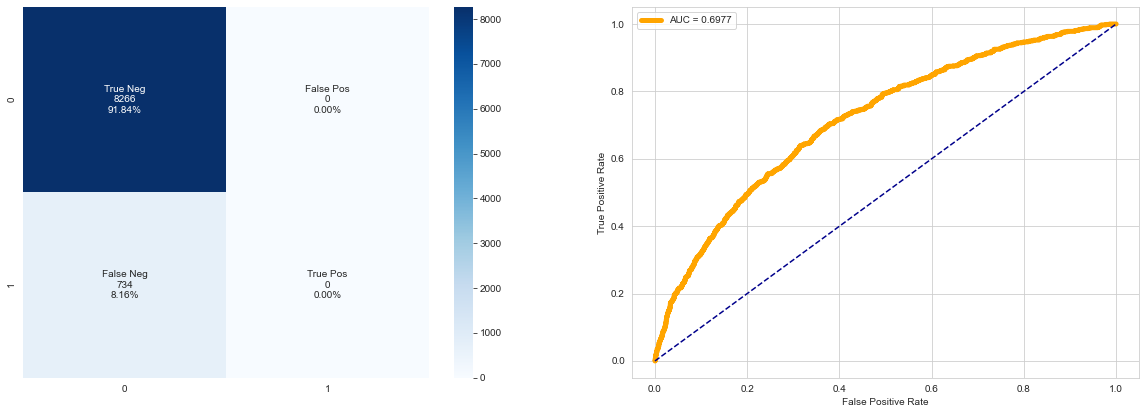

In [56]:
mrf_rfecv = RandomForestClassifier(**mrf_grid_cv.best_params_)
mrf_rfecv.fit(X_train_selected, y_train)
roc_auc_mrf = roc_auc_score(y_test, mrf_rfecv.predict_proba(X_test_selected)[:,1])
print('AUC : %0.4f' %roc_auc_mrf)
print("=="*50)
cf_matrix_roc_auc(mrf_rfecv, y_test, mrf_rfecv.predict(X_test_selected), mrf_rfecv.predict_proba(X_test_selected)[:,1], feature_importances=True,roc_auc=roc_auc,X_data=None)

____

* _Cost Function_ 
___

In [58]:
#FP and FN :
print("Cost function RandomForest:")
print("=="*50)
display(classify_cost_false(mrf_rfecv, y_test, X_test_selected))

Cost function RandomForest:
False Pos: 0.00%
False Neg: 8.16%


(0.0, 0.08155555555555556)

## Conclusion 


Après une baseline faite avec un algorithme simple de régression logistique, l'AUC score avait été estimé ≈ 0.72 avec rééquilibrage (SMOTE) des données. La suite de l'étude a été déroulée vers 2 algorithmes plus complexes. Nous avons pu démontrer les performances de ces algorithmes par une sélection de features, à **`l'origine > 256`**, après **`RFECV 126`**. RandomForest ressort comme étant, le plus performant sur la métrique classique de l'AUC.

La fonction coût permet de pénaliser les erreurs de prédiction qui peuvent coûter cher à l'entreprise. En effet, avec l'implémentation de la métrique métier les FP sont estimés à **0.19 (contre 0.0)**, les FN sont à **0.78 (contre 0.79)**. Au final la métrique métier permet de pénaliser légèrement mieux les erreurs du modèle.

In [59]:
mrf = RandomForestClassifier(**best_forest_params)
mrf.fit(X_train_selected, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=22)

In [60]:
X_train_selected.shape

(21000, 152)

In [62]:
pickle.dump(mrf, open("./model/RandomForestClassifier.pkl", "wb"))